# **DNK RBC MODEL**
By XXXX, YYYYY, and ZZZZ.

This paper aims to compute and forcast a Real Business Cycle Model for the Denmark economy between the years 1950 to 2023.

### **Introduction**
Denmark, given that being a small open economy, tends to be influenced by global economic trends, such as recessions or booms, trade agreements, and international economic conditions. \cite{pedersen2013drives} Pedersen (2013) states that over 50\% of the volatility in Denmark's real GDP can be attributed to foreign shocks. A lot of external variables contributed to the recession that Denmark experienced following the most recent financial crisis. As can be seen from the graphs of our model, the output along with consumption decreased significantly during the 2008-9 financial crisis. What is most striking is that the fall in output and consumption was as severe as during the lockdowns, due to the pandemic. In addition, the effect of the financial crisis can be well seen in the Investment and Trade Balance graphs where the deviation from the trend corresponds to the same period, namely 2008-9 and 2020.

When it comes to the graph, which depicts working hours in Denmark between the years 1988 and 2023, it can be seen that it fluctuated over time, by keeping its decreasing overall trend. Starting with the reduction in working hours in Denmark during the 1990s, \cite{burr2003trends} claims it was primarily driven by labor market and societal changes. Another important variable for the labor market, namely wages, is also presented as a part of our model. The highest wage increase was around 2008-9 by 0.020 with an all-time high. One can conclude that around 2006, the fluctuations fit in a pattern, as the graph suggests. However, the real wage growth has also seen negative parts from time to time, especially before 2008. \cite{} IMF report


Furthermore, it is beneficial to keep in mind that Denmark is a member of the European Union. Thus, changes in EU policies, expansions, or contractions of the EU, directly affect the Danish economy. In this sense, when we look at the graph of interest rates and bond yields, there is an overall decreasing trend. Taking into account that in early July 2012, Danmarks National Bank lowered its monetary-policy interest rates to historically low levels in connection with the ECB reduction of interest rates aligns with the results of our graph. One can say that the negative rate of interest on certificates of deposit was set solely with consideration to maintaining Denmark's fixed-exchange-rate policy. The fixed-exchange-rate policy entails that monetary policy is laid down to stabilize the krone against the euro. \cite{} refer to Denmark National Bank publication.

### **Literature Review**
Dynamic Stochastic General Equilibrium (DSGE) models have become essential tools for understanding economic fluctuations in various economies, including small open economies like Denmark. This literature review explores two key articles that contribute to the understanding of business cycles in the Danish economy through the lens of DSGE models. 

This article investigates the driving forces behind the business cycle in Denmark, employing a DSGE model tailored to the characteristics of a small open economy. The study likely delves into the specific features of the Danish economic landscape, considering factors such as trade openness, exchange rate dynamics, and international spillovers. The unique contribution of the article is identifying the main determinants of the business cycle in Denmark by discussing the role of external shocks and global economic conditions and assessing the effectiveness of monetary and fiscal policies in stabilizing the economy. 

The second article, on the other hand, extends the analysis by incorporating additional features into the DSGE model, focusing on housing, banking, and financial frictions. Such extensions are crucial for capturing the intricacies of the Danish economy, where factors like the housing market and financial sector play pivotal roles. Thus, this study diverges from the former by exploring the interactions between the banking sector and the broader economy and by assessing the implications of financial frictions on the transmission of shocks.

### **Preliminars**


In [51]:
pip install tsdisagg

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsdisagg import disaggregate_series
import statsmodels.api as sm

In [53]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names
def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

## **Download Data**
For this estimation, we will look at different variables fundamental in the Business Cycle analysis. Data are downloaded from the FRED, OCDE, and World Bank databases.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 1950-01-01 to 2023-07-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bonds       147 non-null    float64
 1   Y           115 non-null    float64
 2   C           115 non-null    float64
 3   Kformation  115 non-null    float64
 4   stock       70 non-null     float64
 5   r           755 non-null    float64
 6   Exports     115 non-null    float64
 7   Imports     115 non-null    float64
dtypes: float64(8)
memory usage: 54.0 KB


,Bonds,Y,C,Kformation,stock,r,Exports,Imports
DATE,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,203497.859375,NaN,NaN,NaN
1951-01-01,NaN,NaN,NaN,NaN,206158.671875,NaN,NaN,NaN
1952-01-01,NaN,NaN,NaN,NaN,208901.093750,NaN,NaN,NaN
1953-01-01,NaN,NaN,NaN,NaN,214274.093750,NaN,NaN,NaN
1954-01-01,NaN,NaN,NaN,NaN,220242.234375,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-10-01,2.420667,5.719180e+11,2.528550e+11,1.385479e+11,NaN,1.25,3.607410e+11,3.201785e+11
2022-11-01,NaN,NaN,NaN,NaN,NaN,1.25,NaN,NaN
2023-01-01,2.509667,5.779868e+11,2.534612e+11,1.187667e+11,NaN,NaN,3.741787e+11,3.156046e+11


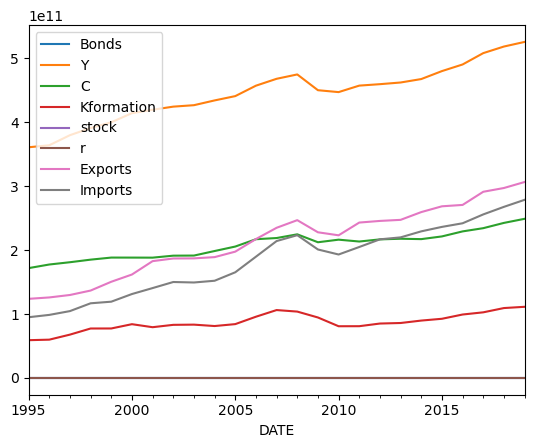

In [54]:
from pandas_datareader.fred import FredReader
fred_indicators = ['IRLTLT01DKQ156N', 'NAEXKP01DKQ189S', 'NAEXKP02DKQ189S', 'NAEXKP04DKQ189S', 'RKNANPDKA666NRUG', 'DNKLOCOSTORSTM', 'NAEXKP06DKQ652S', 'NAEXKP07DKQ652S']

df = FredReader(symbols=fred_indicators, start='1900-01-01', end=None, freq ='Q').read()

df.rename(columns={
    'IRLTLT01DKQ156N': 'Bonds', #monthly 
    'NAEXKP01DKQ189S': 'Y',
    'NAEXKP02DKQ189S': 'C',
    'NAEXKP04DKQ189S': 'Kformation',
    'RKNANPDKA666NRUG': 'stock', #annual
    'DNKLOCOSTORSTM': 'r', #monthly 
    'NAEXKP06DKQ652S': 'Exports',
    'NAEXKP07DKQ652S': 'Imports'
}, inplace=True)
df.to_csv('custom_df.csv')
df.dropna().plot()
df.info()
df

In [55]:
stock = df['stock']
#setting it up in years so it stops giving me missing values error since im going from low to higher frequency with stocks 
stock = df['stock'].resample('YS').last().dropna()
stock_quarterly = disaggregate_series(stock, target_freq='QS', agg_func='last')
r = df['r'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
r_decimal = r.mul(1 / 100)
r_quarterly = r_decimal.resample('QS').agg(compound_interest)
r_quarterly = r_quarterly + 1
r_quarterly
Br = df['Bonds'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
Br_decimal = Br.mul(1 / 100)
Br_quarterly = Br_decimal.resample('QS').agg(compound_interest)
Br_quarterly = Br_quarterly + 1
Br_quarterly

DATE
1987-01-01    1.114351
1987-04-01    1.111149
1987-07-01    1.111370
1987-10-01    1.114504
1988-01-01    1.102015
                ...   
2022-07-01    1.017203
2022-10-01    1.024207
2023-01-01    1.025097
2023-04-01    1.025690
2023-07-01    1.027630
Freq: QS-JAN, Name: Bonds, Length: 147, dtype: float64

In [56]:
df1 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/ANHRS/DNK.DE+TE.A/OECD?contentType=csv')
df1.to_csv('df1.csv')
df1 = df1[df1['Employment status'] == 'Total employment']
hours = df1.loc[:,['Time','Value']]
hours = hours.rename(columns= {'Value': 'N'})
hours['Time'] = pd.to_datetime(hours['Time'], format='%Y')
hours.set_index('Time', inplace=True)
quarterly_N = disaggregate_series(hours, target_freq='QS', agg_func='sum')
quarterly_N

1970-01-01    462.788670
1970-04-01    462.208044
1970-07-01    461.046792
1970-10-01    459.304914
1971-01-01    456.982409
                 ...    
2021-10-01    342.374966
2022-01-01    342.655797
2022-04-01    342.866420
2022-07-01    343.006836
2022-10-01    343.077043
Freq: QS-OCT, Name: N, Length: 212, dtype: float64

In [57]:
df1.dropna(inplace=True) 
print("Remaining missing values:", df1.isnull().sum().sum())

Remaining missing values: 0


In [58]:
df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
df2.to_csv('df2.csv')
df2 = df2[df2['Subject'] == 'Manufacturing, Index']
wages = df2.loc[:,['Time','Value']]
wages = wages.rename(columns= {'Value': 'w'})
wages['Time'] = wages['Time'].apply(lambda x: x[3:] + "-" + "Q" + x[1])
wages['Time'] = pd.to_datetime(wages['Time'])
wages.set_index('Time', inplace=True)
wages.head()

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_11596\2957788866.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_11596\2957788866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
C:\Users\PAVILION\AppData\Local

,w
Time,
1971-01-01,6.801153
1971-04-01,7.283459
1971-07-01,7.472557
1971-10-01,7.702024
1972-01-01,7.810383


In [59]:
df_quarterly = pd.DataFrame()

In [60]:
df_quarterly['Br_quarterly'] = Br_quarterly
df_quarterly['r_quarterly'] = r_quarterly
df_quarterly['stock_quarterly'] = stock_quarterly
C = df['C']
df_quarterly['C_quarterly'] = C
Y = df['Y']
df_quarterly['Y_quarterly'] = Y
K = df['Kformation']
df_quarterly['K_quarterly'] = K
EX = df['Exports']
df_quarterly['EX_quarterly'] = EX
IM = df['Imports']
df_quarterly['IM_quarterly'] = IM
df_quarterly

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly
DATE,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11


In [61]:
merged = df_quarterly.join([quarterly_N, wages])
merged

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN,376.969796,36.85957
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN,374.055140,38.62382
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN,371.798882,38.72432
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN,370.201021,39.53945
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN,369.261557,39.55061
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11,343.006836,117.93010
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11,343.077043,118.15920
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11,NaN,118.84670


In [62]:
merged.dropna(inplace=True) 
print("Remaining missing values:", merged.isnull().sum().sum())
merged.head()

Remaining missing values: 0


,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1995-01-01,1.089600,1.168650,939142.859375,1.717697e+11,3.608200e+11,5.903179e+10,1.237207e+11,9.494988e+10,353.569687,52.22259
1995-04-01,1.084437,1.191016,943527.093750,1.737711e+11,3.597877e+11,5.976629e+10,1.213563e+11,9.632093e+10,355.063215,52.76544
1995-07-01,1.080877,1.165894,947911.328125,1.746535e+11,3.612882e+11,6.266278e+10,1.207843e+11,9.678716e+10,355.532891,53.25401
1995-10-01,1.075830,1.146620,952295.562500,1.750917e+11,3.639317e+11,6.607297e+10,1.221478e+11,9.977737e+10,354.978715,53.74258
1996-01-01,1.073490,1.122160,957127.187500,1.774266e+11,3.639864e+11,5.985612e+10,1.259050e+11,9.859263e+10,353.400688,54.28543


Br_quarterly


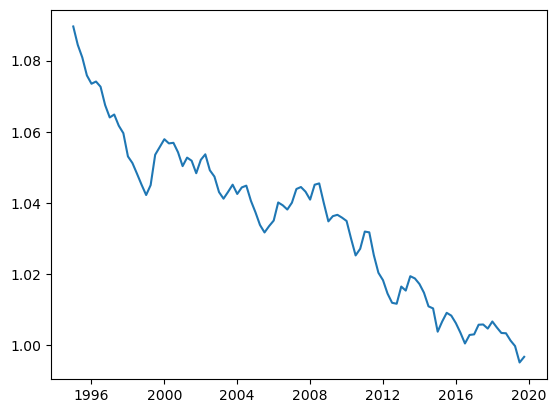

r_quarterly


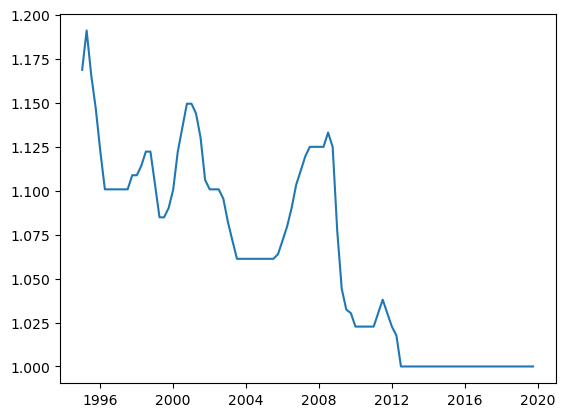

stock_quarterly


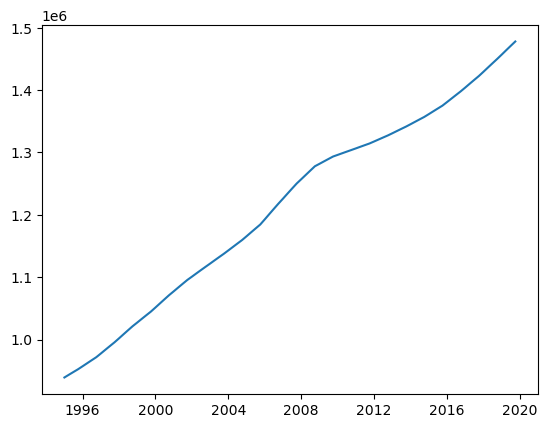

C_quarterly


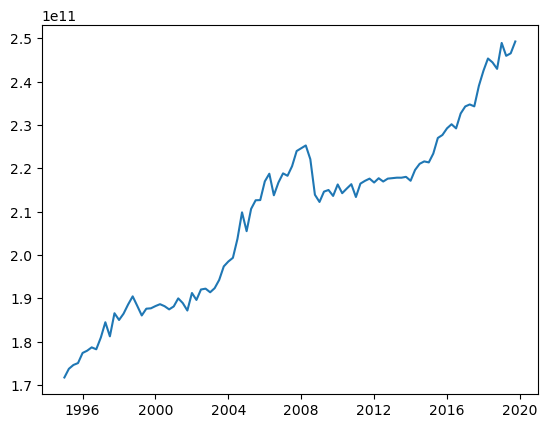

Y_quarterly


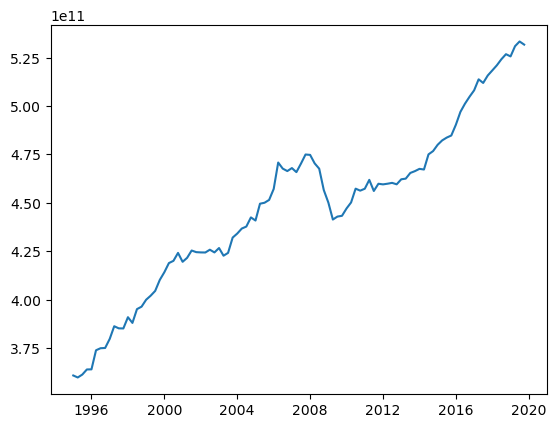

K_quarterly


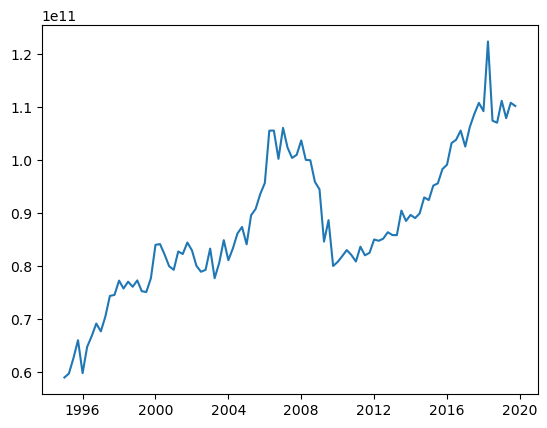

EX_quarterly


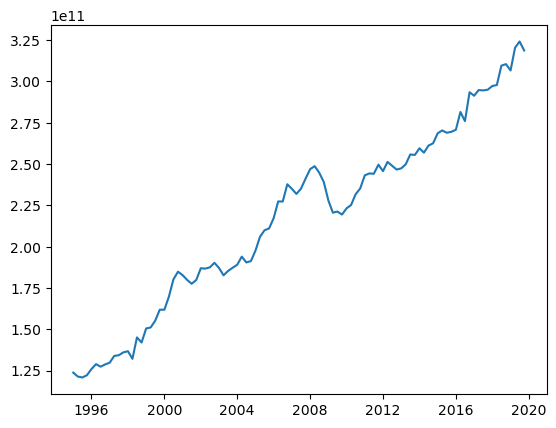

IM_quarterly


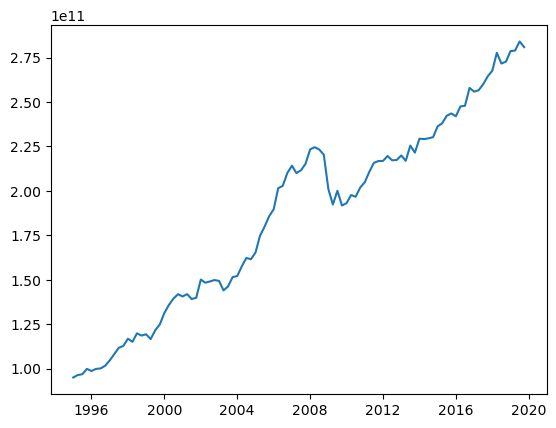

N


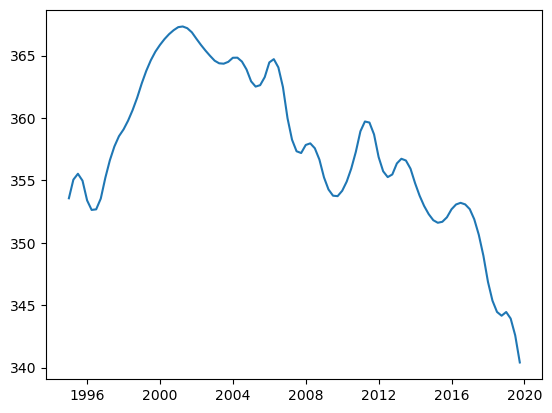

w


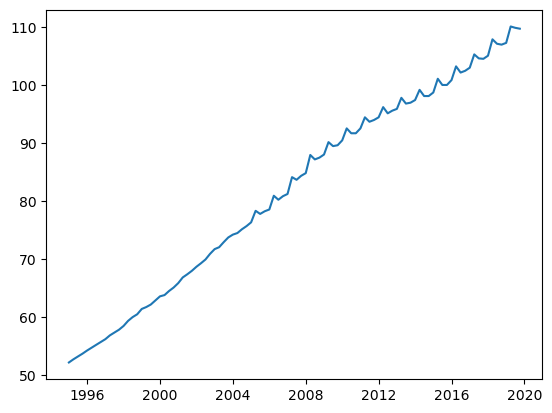

In [63]:
for columns in merged.columns:
    print(columns)
    column_data = merged[columns].dropna()
    plt.plot(column_data, label=columns)
    plt.show()

<Axes: xlabel='DATE', ylabel='Resid'>

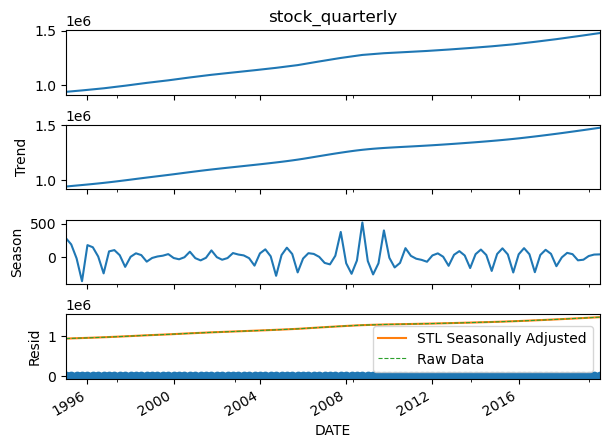

In [64]:
#Let's start with stock, aka investment 
stl_res= sm.tsa.STL(merged.stock_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['stock_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['stock_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

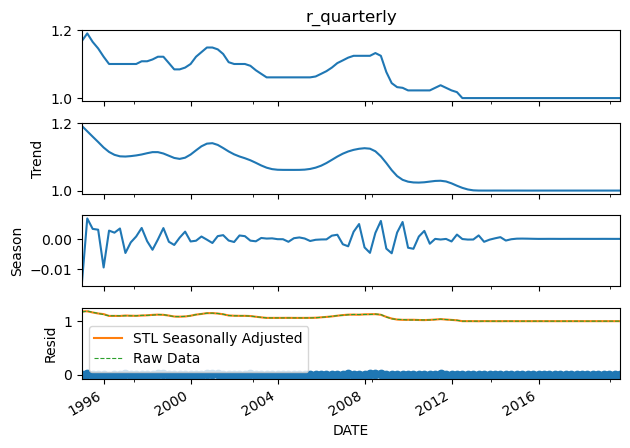

In [65]:
#now for r
stl_res= sm.tsa.STL(merged.r_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['r_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['r_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

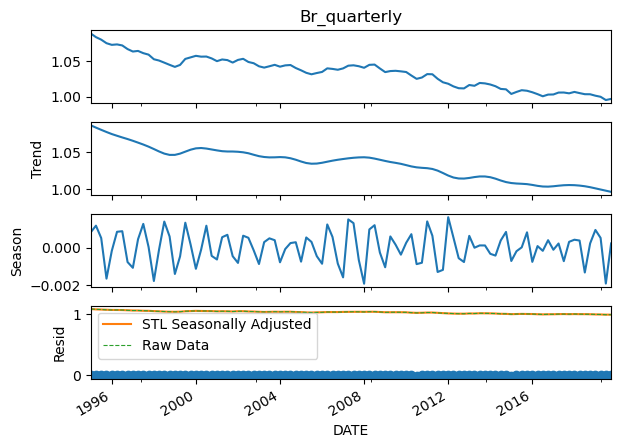

In [66]:
#finally, for bonds 
stl_res= sm.tsa.STL(merged.Br_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['Br_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['Br_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

Seasonal adjustment is done, moving on to de-trending.
Let's start with everything but the rates 

<Axes: xlabel='DATE'>

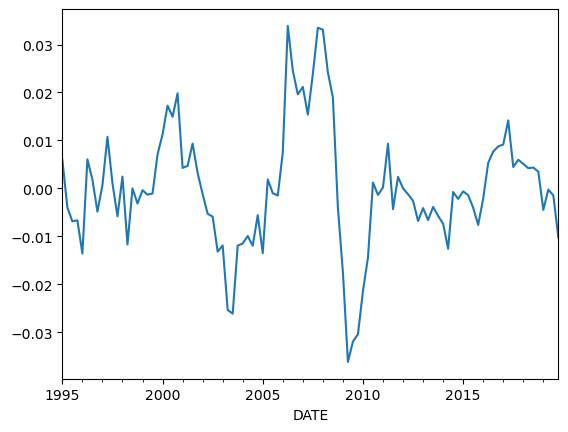

In [67]:
#starting with Y 
LogY = np.log(merged['Y_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogY)
LogY = cycle
LogY.plot()

<Axes: xlabel='DATE'>

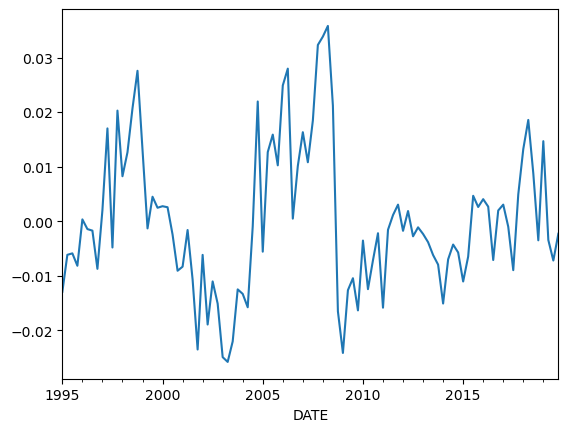

In [68]:
#now C  
LogC = np.log(merged['C_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogC)
C = LogC = cycle
C.plot()

<Axes: xlabel='DATE'>

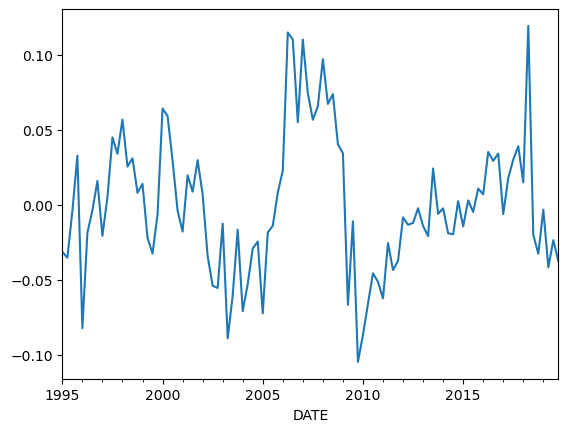

In [69]:
#now K
LogK = np.log(merged['K_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogK)
K = LogK = cycle
K.plot()

In [70]:
#de-trending rates:
merged['r_quarterly'] = merged['r_quarterly'] - merged['r_quarterly'].mean()
merged['Br_quarterly'] = merged['Br_quarterly'] - merged['Br_quarterly'].mean()

<Axes: xlabel='DATE'>

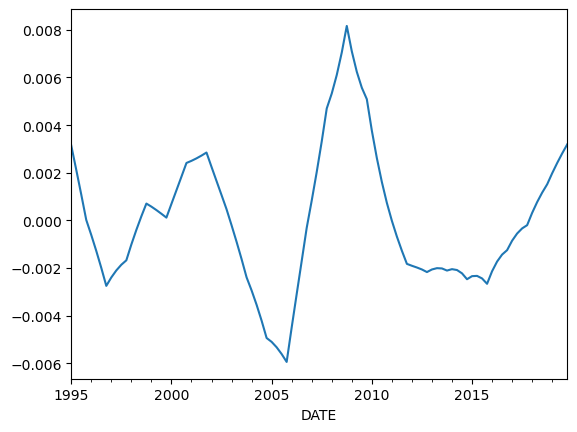

In [71]:
merged['stock_quarterly'] = merged['stock_quarterly'].dropna()
LogI= np.log(merged['stock_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogI)
I = LogI = cycle
I.plot()

<Axes: xlabel='DATE'>

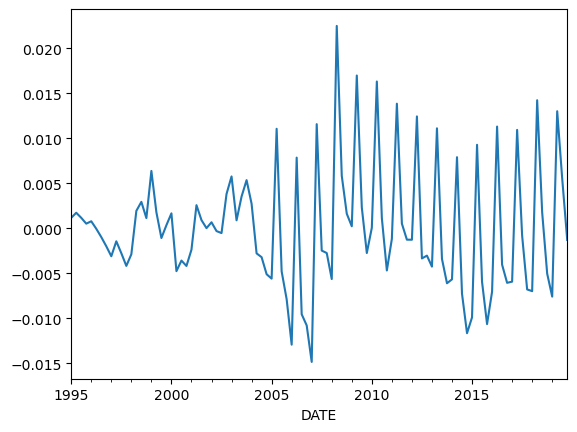

In [72]:
Logw= np.log(merged['w'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(Logw)
w = Logw = cycle
w.plot()

<Axes: xlabel='DATE'>

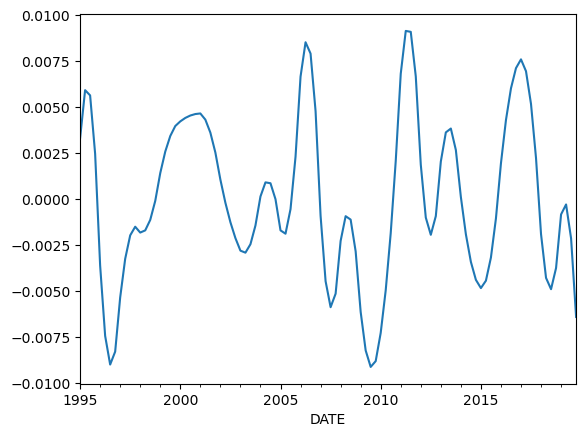

In [73]:
LogN= np.log(merged['N'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogN)
N = LogN = cycle
N.plot()

In [74]:
#now make the trade balance variables 
TB = EX - IM
TB_to_Y = TB / Y
merged ['TB_to_Y'] = TB_to_Y

In [75]:
processed = pd.DataFrame()
processed['Y'] = LogY
processed['C'] = C
processed['I'] = I
processed['K'] = K
processed['TB_to_Y'] = merged['TB_to_Y']
processed['N'] = N
processed['r'] = merged['r_quarterly']
processed['w'] = w
processed['R'] = merged['Br_quarterly']
processed

,Y,C,I,K,TB_to_Y,N,r,w,R
DATE,,,,,,,,,
1995-01-01,0.005956,-0.012950,0.003148,-0.031336,0.079737,0.003314,0.105556,0.001157,0.054716
1995-04-01,-0.003977,-0.006173,0.002130,-0.035218,0.069584,0.005925,0.127922,0.001721,0.049553
1995-07-01,-0.006886,-0.005908,0.001089,-0.004120,0.066421,0.005641,0.102800,0.001159,0.045993
1995-10-01,-0.006673,-0.008181,0.000021,0.032705,0.061469,0.002468,0.083525,0.000511,0.040946
1996-01-01,-0.013601,0.000323,-0.000609,-0.082173,0.075037,-0.003618,0.059066,0.000776,0.038606
...,...,...,...,...,...,...,...,...,...
2018-10-01,0.003486,-0.003515,0.001517,-0.032540,0.071514,-0.003751,-0.063094,-0.005044,-0.031591
2019-01-01,-0.004496,0.014666,0.001982,-0.003216,0.053014,-0.000835,-0.063094,-0.007589,-0.033651
2019-04-01,-0.000271,-0.003463,0.002412,-0.041605,0.077872,-0.000293,-0.063094,0.012997,-0.035187


(90, 9)
(90, 9)
Y


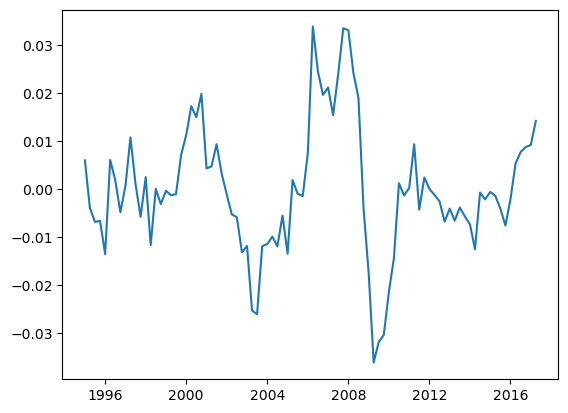

C


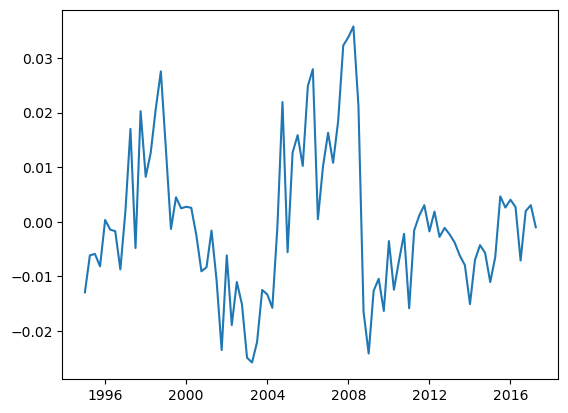

I


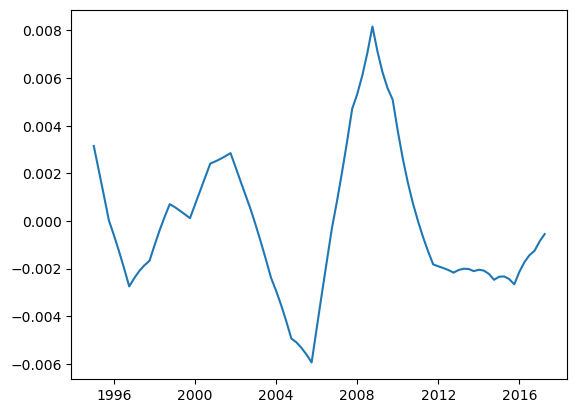

K


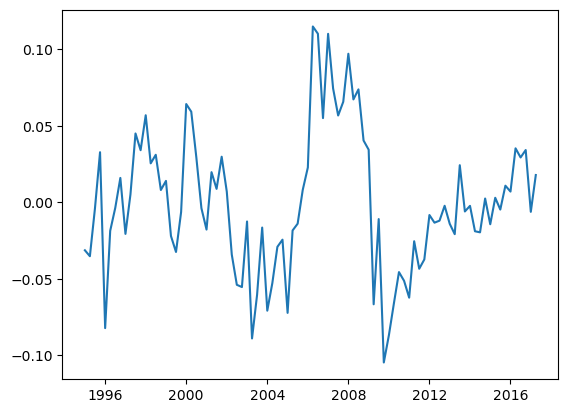

TB_to_Y


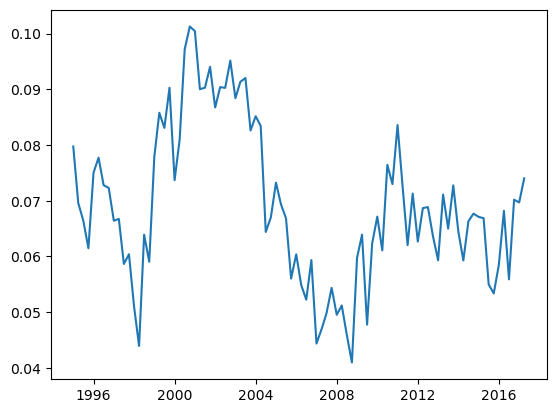

N


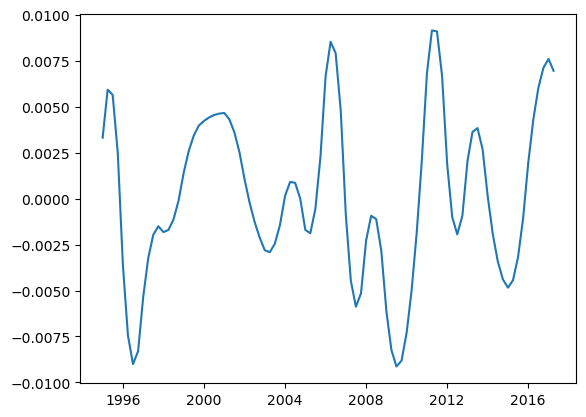

r


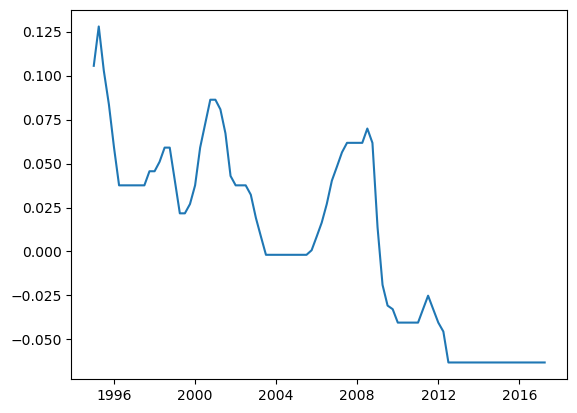

w


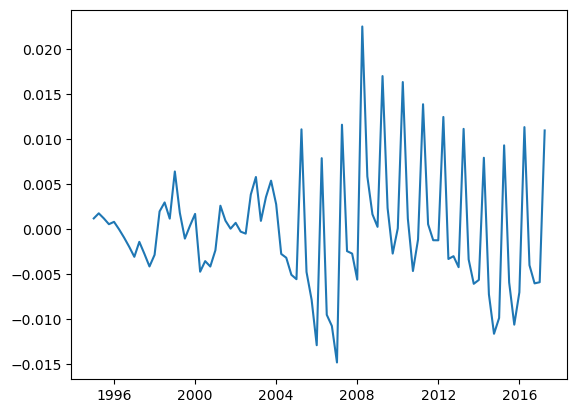

R


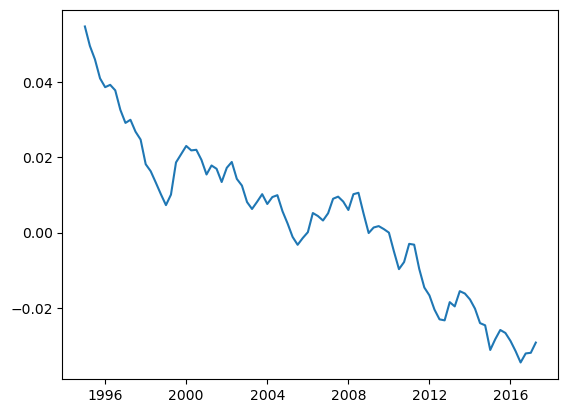

In [76]:
#train/split
n_test=10
processed_train = processed.iloc[:-n_test, :].copy()
processed_test= processed.iloc[:-n_test, :].copy()
print(processed_train.shape)
print(processed_test.shape)
for columns in processed_train.columns:
    print(columns)
    columntrain_data = processed_train[columns].dropna()
    plt.plot(columntrain_data, label=columns)
    plt.show()

In [77]:
ADF_test_summary(processed_train, missing = 'drop') 

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.178         -2.850        0.179          0    -4.064      -3.461     -3.157
	Constant            -0.001         -0.303        0.762
	Trend                0.000          0.378        0.707
Constant Only               -0.179         -2.879        0.048          0    -3.506      -2.895     -2.584
	Constant             0.000          0.050        0.960
No Constant                 -0.179         -2.897        0.004          0    -2.591      -1.944     -1.614
                                                      C                                                       
Specification               Coeff          Statistic     P-value      La

## **The Model**
### **Calibration and the Data**

Estimation of the model below requires quarterly data on consumption, investment, rental rate of capital, GDP, labour and wage.

To calibrate our parameters, we refer to the two articles discussed in the literature review section. Starting with the discount factor β, while one finds it to be 0.99, the other records it as 0.9975. For our model, we chose a value of 0.99 as it is commonly used as default in other such paper for computational efficiency. Both papers have calibrated the depreciation of capital stock δ at 0.025, as we do here. As for the share of capital income from GDP, α, both models have also recorded it as 0.3 which we adopt. Labor disutility parameter, ω, is a rather interesting case. While one marks it down as 2.5, the other estimated it at 5.5. As a middle ground, we set ω to 3. Moving to temporary technology shock, Denmark seems to score relatively highly. Indeed, in both papers, the parameter for ρ ranged between 0.8 and 0.85. We set ρ to 0.85. We find ψ in our first article marked down as 0.02, and this is what we adopt for this model. Consequently, ψ² is 0.004. As for the risk aversion γ, the utility function used in our first article estimates it as log (C ) = 1. We chose a smaller value of 1.5 to fit the model. Finally, as for r*, we calculate it using the following formula rstar =1/(β-1). As such, is set to 0.0101010. 


In comparing US and Danish parameters, we find that US and Danish populations exhibit similar household preferences in terms of spending and saving as per their discount factors. However, American households seem more risk averse, tending towards safer investments. Contrasted with a Danish population that seems by far to have a much higher preference for leisure over work and their lower capital share of the GDP, the US economy seems to be both more capital intensive and more productive, both of which are often interlinked. In terms monetary policy, the US seems to adopt a more hands on approach with its higher ψ² rate, suggesting a higher responsiveness and proactiveness in managing economic conditions than that of Danish  policymakers. Finally, Denmark’s  ρ in much higher than that of the US economy, indicating that (i) TFP shocks have much more persistence over time in Denmark; (ii) the Danish economy takes more time to adjust to such shocks whereas the US economy faces much less resistance to technological changes; (iii) the Danish economy is much less volatile than the US economy and would exhibit much stabler growth patterns and (iv) the Danish economy is much more predictable for policy makers and investors. 

In [78]:
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp

import numpy as np
import sympy as sp

print(f"Running gEconpy version {ge.__version__}")

Running gEconpy version 1.2.1


In [79]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w'] 


In [80]:
open_rbc = ge.gEconModel("D:/Phyton_user/Modelo_RBC.cgn")

Model Building Complete.
Found:
	14 equations
	14 variables
	The following variables were eliminated at user request:
		U_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	11 parameters
		 0 / 11 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [81]:
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol

for var, eq in open_rbc.steady_state_relationships.items():
    sp_var = TimeAwareSymbol(var.split("_")[0], time_index="ss")
    display(sp.Eq(sp_var, eq))

Eq(A_ss, 1.0)

Eq(CA_ss, 0.0)

Eq(C_ss, IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha))

Eq(Cadjcost_ss, 0.0)

Eq(IIP_ss, IIPbar)

Eq(I_ss, delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(K_ss, (alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(KtoN_ss, (alpha/(delta + rstar))**(1/(1 - alpha)))

Eq(N_ss, ((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))

Eq(TB_ss, -IIPbar*rstar)

Eq(TBtoY_ss, -IIPbar*rstar*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(alpha - 1)/((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha)

Eq(U_ss, ((IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(1 - gamma) - 1)/((1 - beta)*(1 - gamma)))

Eq(Y_ss, ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha))

Eq(lambda_ss, (IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(-gamma))

Eq(r_ss, rstar)

Eq(r_ss, rstar)

Eq(u_ss, ((IIPbar*rstar - delta*(alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)) + ((alpha/(delta + rstar))**(1/(1 - alpha))*((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**alpha*(((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**(1 - alpha) - (((1 - alpha)*((alpha/(delta + rstar))**(1/(1 - alpha)))**alpha)**(1/(omega - 1*1)))**omega/omega)**(1 - gamma) - 1)/(1 - gamma))

In [82]:
for equation in open_rbc.system_equations:
    display(equation)

-psi*(K_t - K_t-1)**2/2 + A_t*K_t-1**alpha*N_t**(1 - alpha) - C_t - K_t + K_t-1*(1 - delta) - TB_t

K_t/N_t - KtoN_t

-TBtoY_t + N_t**(alpha - 1)*TB_t/(A_t*K_t-1**alpha)

-CA_t + IIP_t-1*r_t-1 + TB_t

psi2*(exp(IIPbar - IIP_t) - 1*1) + rstar - r_t

-r_given_t + r_t

-1*psi*(K_t - K_t-1)**2/2 + A_t*K_t-1**alpha*N_t**(1 - alpha) - C_t - IIP_t + IIP_t-1*(r_given_t-1 + 1) - K_t + K_t-1*(1 - delta)

-lambda_t + (C_t - N_t**omega/omega)**(-gamma)

A_t*K_t-1**alpha*lambda_t*(1 - alpha)/N_t**alpha - N_t**(omega - 1)/(C_t - N_t**omega/omega)**gamma

-beta*lambda_t+1*(-alpha*A_t+1*K_t**(alpha - 1)*N_t+1**(1 - alpha) + delta + psi*(2*K_t - 2*K_t+1)/2 - 1) - lambda_t*(psi*(2*K_t - 2*K_t-1)/2 + 1)

-beta*lambda_t+1*(-r_given_t - 1) - lambda_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

-I_t + K_t - K_t-1*(1 - delta)

A_t*K_t-1**alpha*N_t**(1 - alpha) - Y_t

## Solve the Steady State

In [83]:
open_rbc.steady_state()

Steady state found! Sum of squared residuals is 3.2223082197240875e-17


In [84]:

# Pull out Y_ss and r_ss from the steady state
Y_zero = open_rbc.steady_state_dict['Y_ss']
r_ss = open_rbc.steady_state_dict['r_ss']



In [86]:
# Compute IIP_ss using the formula above
IIP_ss = -processed_train.TB_to_Y.mean() / r_ss * Y_zero
IIP_ss

-22.781376377991315

In [87]:
# Set the new IIP_bar parameter
open_rbc.free_param_dict['IIPbar'] = IIP_ss

# Re-solve the steady-state
open_rbc.steady_state()

Steady state found! Sum of squared residuals is 4.813525081779425e-17


In [88]:
open_rbc.print_steady_state()

A_ss                1.000
CA_ss               0.000
C_ss                2.383
IIP_ss            -22.781
I_ss                0.710
K_ss               28.403
KtoN_ss            21.436
N_ss                1.325
TB_ss               0.230
TBtoY_ss            0.069
Y_ss                3.323
lambda_ss           0.491
r_given_ss          0.010
r_ss                0.010


## Model Stability 

In [96]:
open_rbc.solve_model(not_loglin_variable=['CA', 'TB'])

Solution found, sum of squared residuals:  1.561401070744248e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [97]:
open_rbc.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,1.133381e-28,-1.133381e-28,-0.0
1,1.720658e-18,-1.720658e-18,-0.0
2,3.785261e-18,-3.785261e-18,-0.0
3,1.013168e-16,-1.013168e-16,-0.0
4,4.563025e-16,4.563025e-16,0.0
5,7.925467e-01,7.925467e-01,0.0
6,8.500000e-01,8.500000e-01,0.0
7,9.896352e-01,9.896352e-01,0.0
8,1.026656e+00,1.026656e+00,0.0
9,1.278513e+00,1.278513e+00,0.0


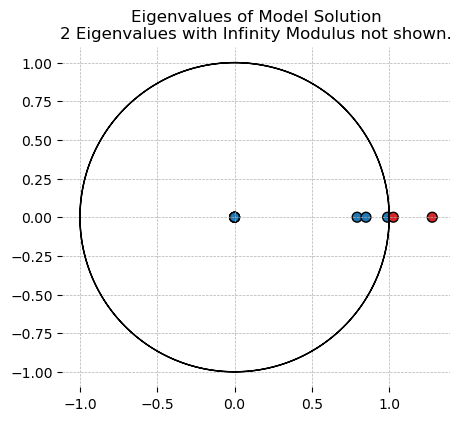

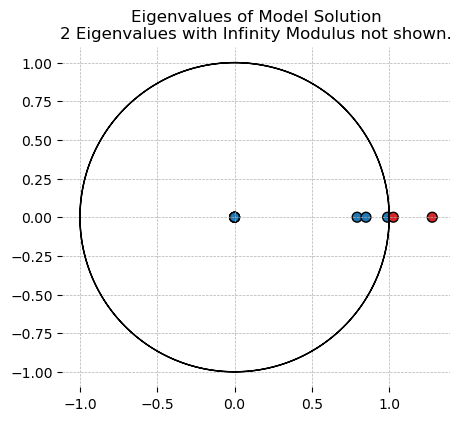

In [98]:
gp.plot_eigenvalues(open_rbc)


## Impulse Response Functions 

In [103]:
irf = open_rbc.impulse_response_function(shock_size=0.03)

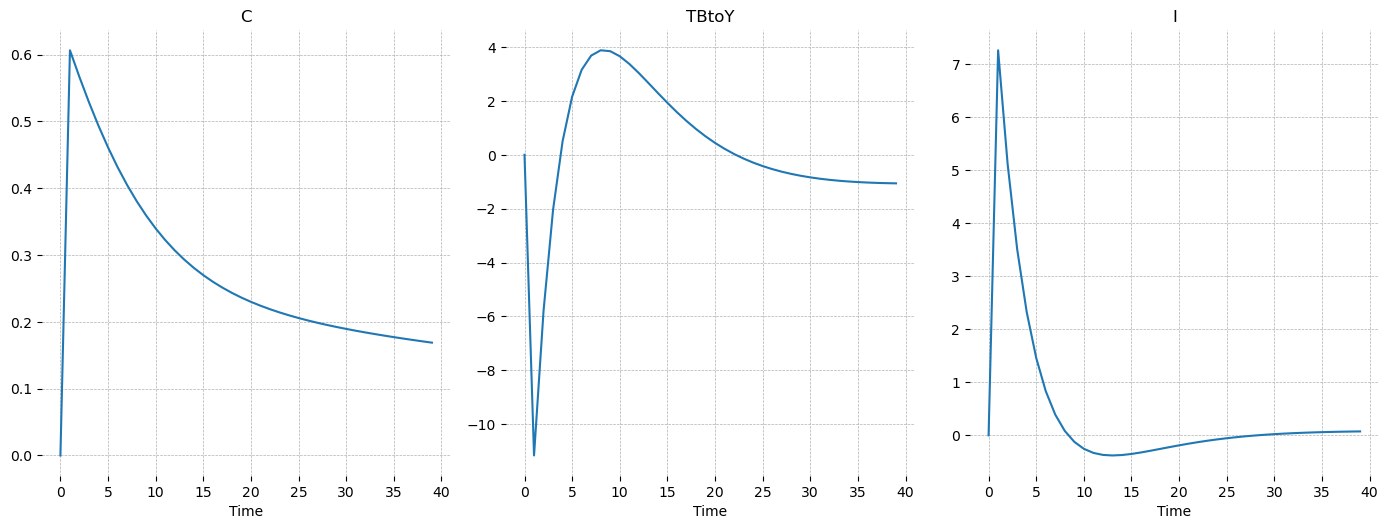

In [105]:
gp.plot_irf(irf, vars_to_plot=['C', 'TBtoY', 'I']);

## Model Statistics and Simulations


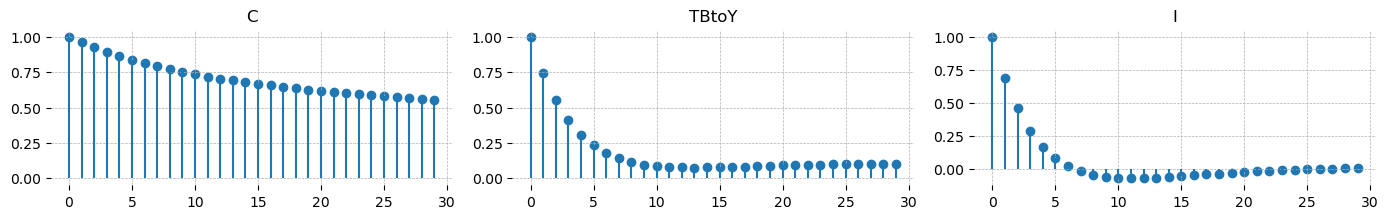

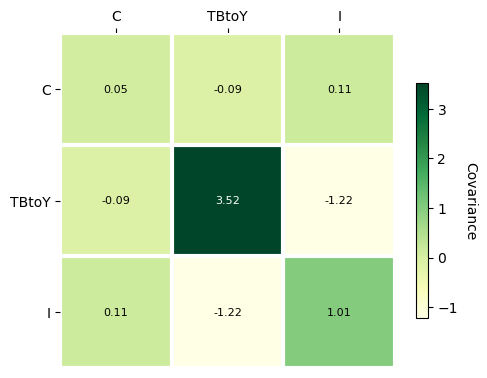

In [107]:
sigma = open_rbc.compute_stationary_covariance_matrix()

acorr_matrix = open_rbc.compute_autocorrelation_matrix(n_lags=30)

gp.plot_acf(acorr_matrix, vars_to_plot=['C', 'TBtoY', 'I'], n_cols=3);

gp.plot_covariance_matrix(sigma, ['C', 'TBtoY', 'I'],
                          figsize=(5,5),
                          cbar_kw=dict(shrink=0.5));

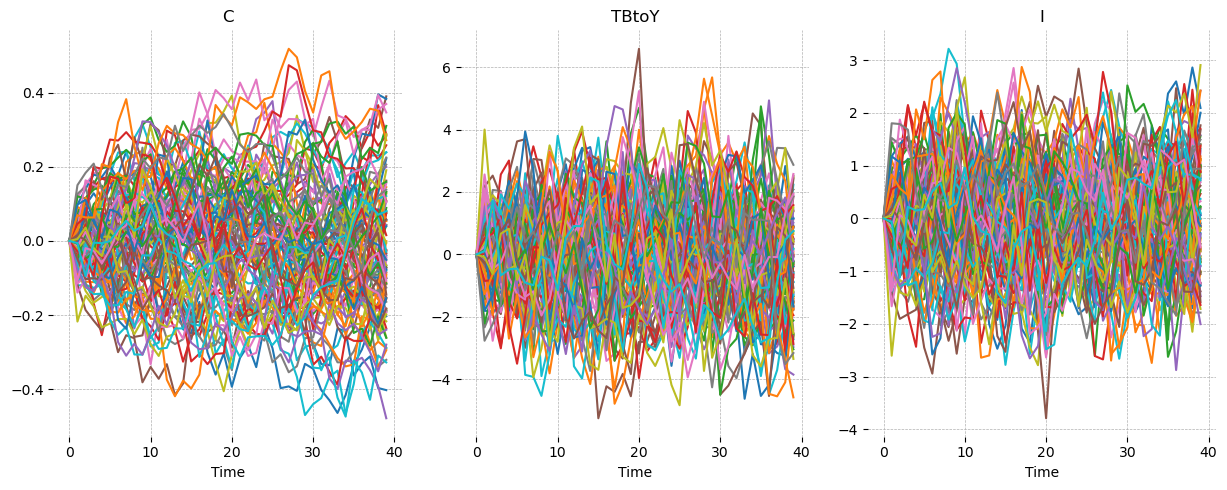

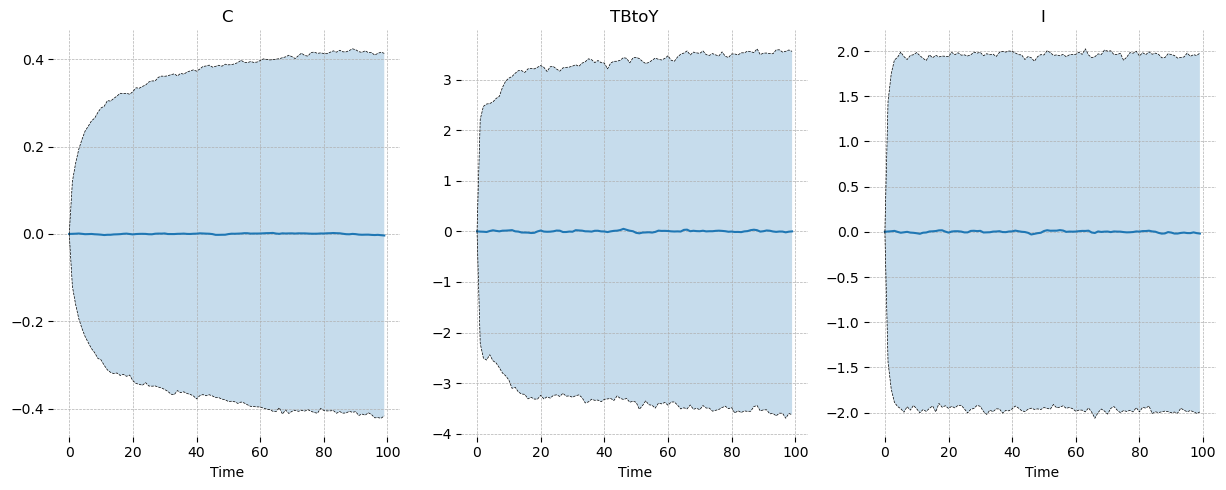

In [108]:
#Simulation 
simulation = open_rbc.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=100)

gp.plot_simulation(simulation, vars_to_plot=['C', 'TBtoY', 'I'],
                   n_cols=4, figsize=(16, 5));



simulation = open_rbc.simulate(
    shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10_000, simulation_length=100
)
gp.plot_simulation(
    simulation,
    vars_to_plot=['C', 'TBtoY', 'I'],
    ci=0.95,
    n_cols=4,
    figsize=(16, 5),
);

## Estimations


In [118]:
MLEModel = ge.compile_to_statsmodels(open_rbc)


In [126]:
from gEconpy.classes.transformers import PositiveTransformer, IntervalTransformer

param_start_dict = {
    "rho_A": 0.42,
}

shock_start_dict = {"epsilon_A": 0.1}
noise_start_dict = {'TB_to_Y':0.01}

# We will 100% trust the GDP data, so noise_start_dict is empty.
noise_start_dict = {}

# Don't actually pick 0 and 1, because you can get divide by zero errors. Instead pick numbers really close.
param_transforms = {'rho_A':IntervalTransformer(low=1e-4, high=0.9999)}


# The model 
mle_mod = MLEModel(
    processed_train.dropna(),
    param_start_dict=param_start_dict,
    shock_start_dict=shock_start_dict,
    noise_start_dict=noise_start_dict,
    param_transforms=param_transforms,
    shock_transforms=None,  # If None, will automatically transform to positive values only
    noise_transforms=None,  # If None, will automatically transform to positive values only
    initialization="stationary",
    fit_MAP=False
)


C:\Users\PAVILION\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['constant', 'initial_state_cov']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ValueError: Data contains the following columns not associated with variables in the model:TB_to_Y, w, R

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mle_res = mle_mod.fit(method="basinhopping", 
                          T=1, 
                          niter=10_000, 
                          niter_success=250, 
                          stepsize=0.1,
                          target_accept_rate=0.5,
                          minimizer={'method':'newton-cg'})

In [ ]:
# Plot the results for visual inspection
plot_sm_results(mle_res, df_train_processed, var_names=vars_to_plot)